In [1]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error,r2_score,mean_squared_log_error
# import trainning data
data = pd.read_csv(r'c:\Users\DUSHYANT\Downloads\playground-series-s5e5\train.csv')
data.drop(columns=["id","Sex"],inplace=True)
# data=pd.get_dummies(data,columns=["Sex"],drop_first=True)

In [2]:
data


,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,36,189.0,82.0,26.0,101.0,41.0,150.0
1,64,163.0,60.0,8.0,85.0,39.7,34.0
2,51,161.0,64.0,7.0,84.0,39.8,29.0
3,20,192.0,90.0,25.0,105.0,40.7,140.0
4,38,166.0,61.0,25.0,102.0,40.6,146.0
...,...,...,...,...,...,...,...
749995,28,193.0,97.0,30.0,114.0,40.9,230.0
749996,64,165.0,63.0,18.0,92.0,40.5,96.0
749997,60,162.0,67.0,29.0,113.0,40.9,221.0
749998,45,182.0,91.0,17.0,102.0,40.3,109.0


Feature Engineering

In [3]:
data_shape=data.shape[1]

In [ ]:
for i in range(data_shape):
    for j in range(i,data_shape):
        if data.columns[i]!="Calories" and data.columns[j]!="Calories":
            print(i,j)
            data[f"{data.columns[i]}*{data.columns[j]}"]=data[data.columns[i]]*data[data.columns[j]]

In [6]:
corr_matrix=data.corr()
corr_matrix_calorie=corr_matrix[["Calories"]].sort_values(by="Calories",ascending=False)

In [7]:
# calorie_corr = data.corrwith(data["Calories"]).sort_values(ascending=False)

<Axes: >

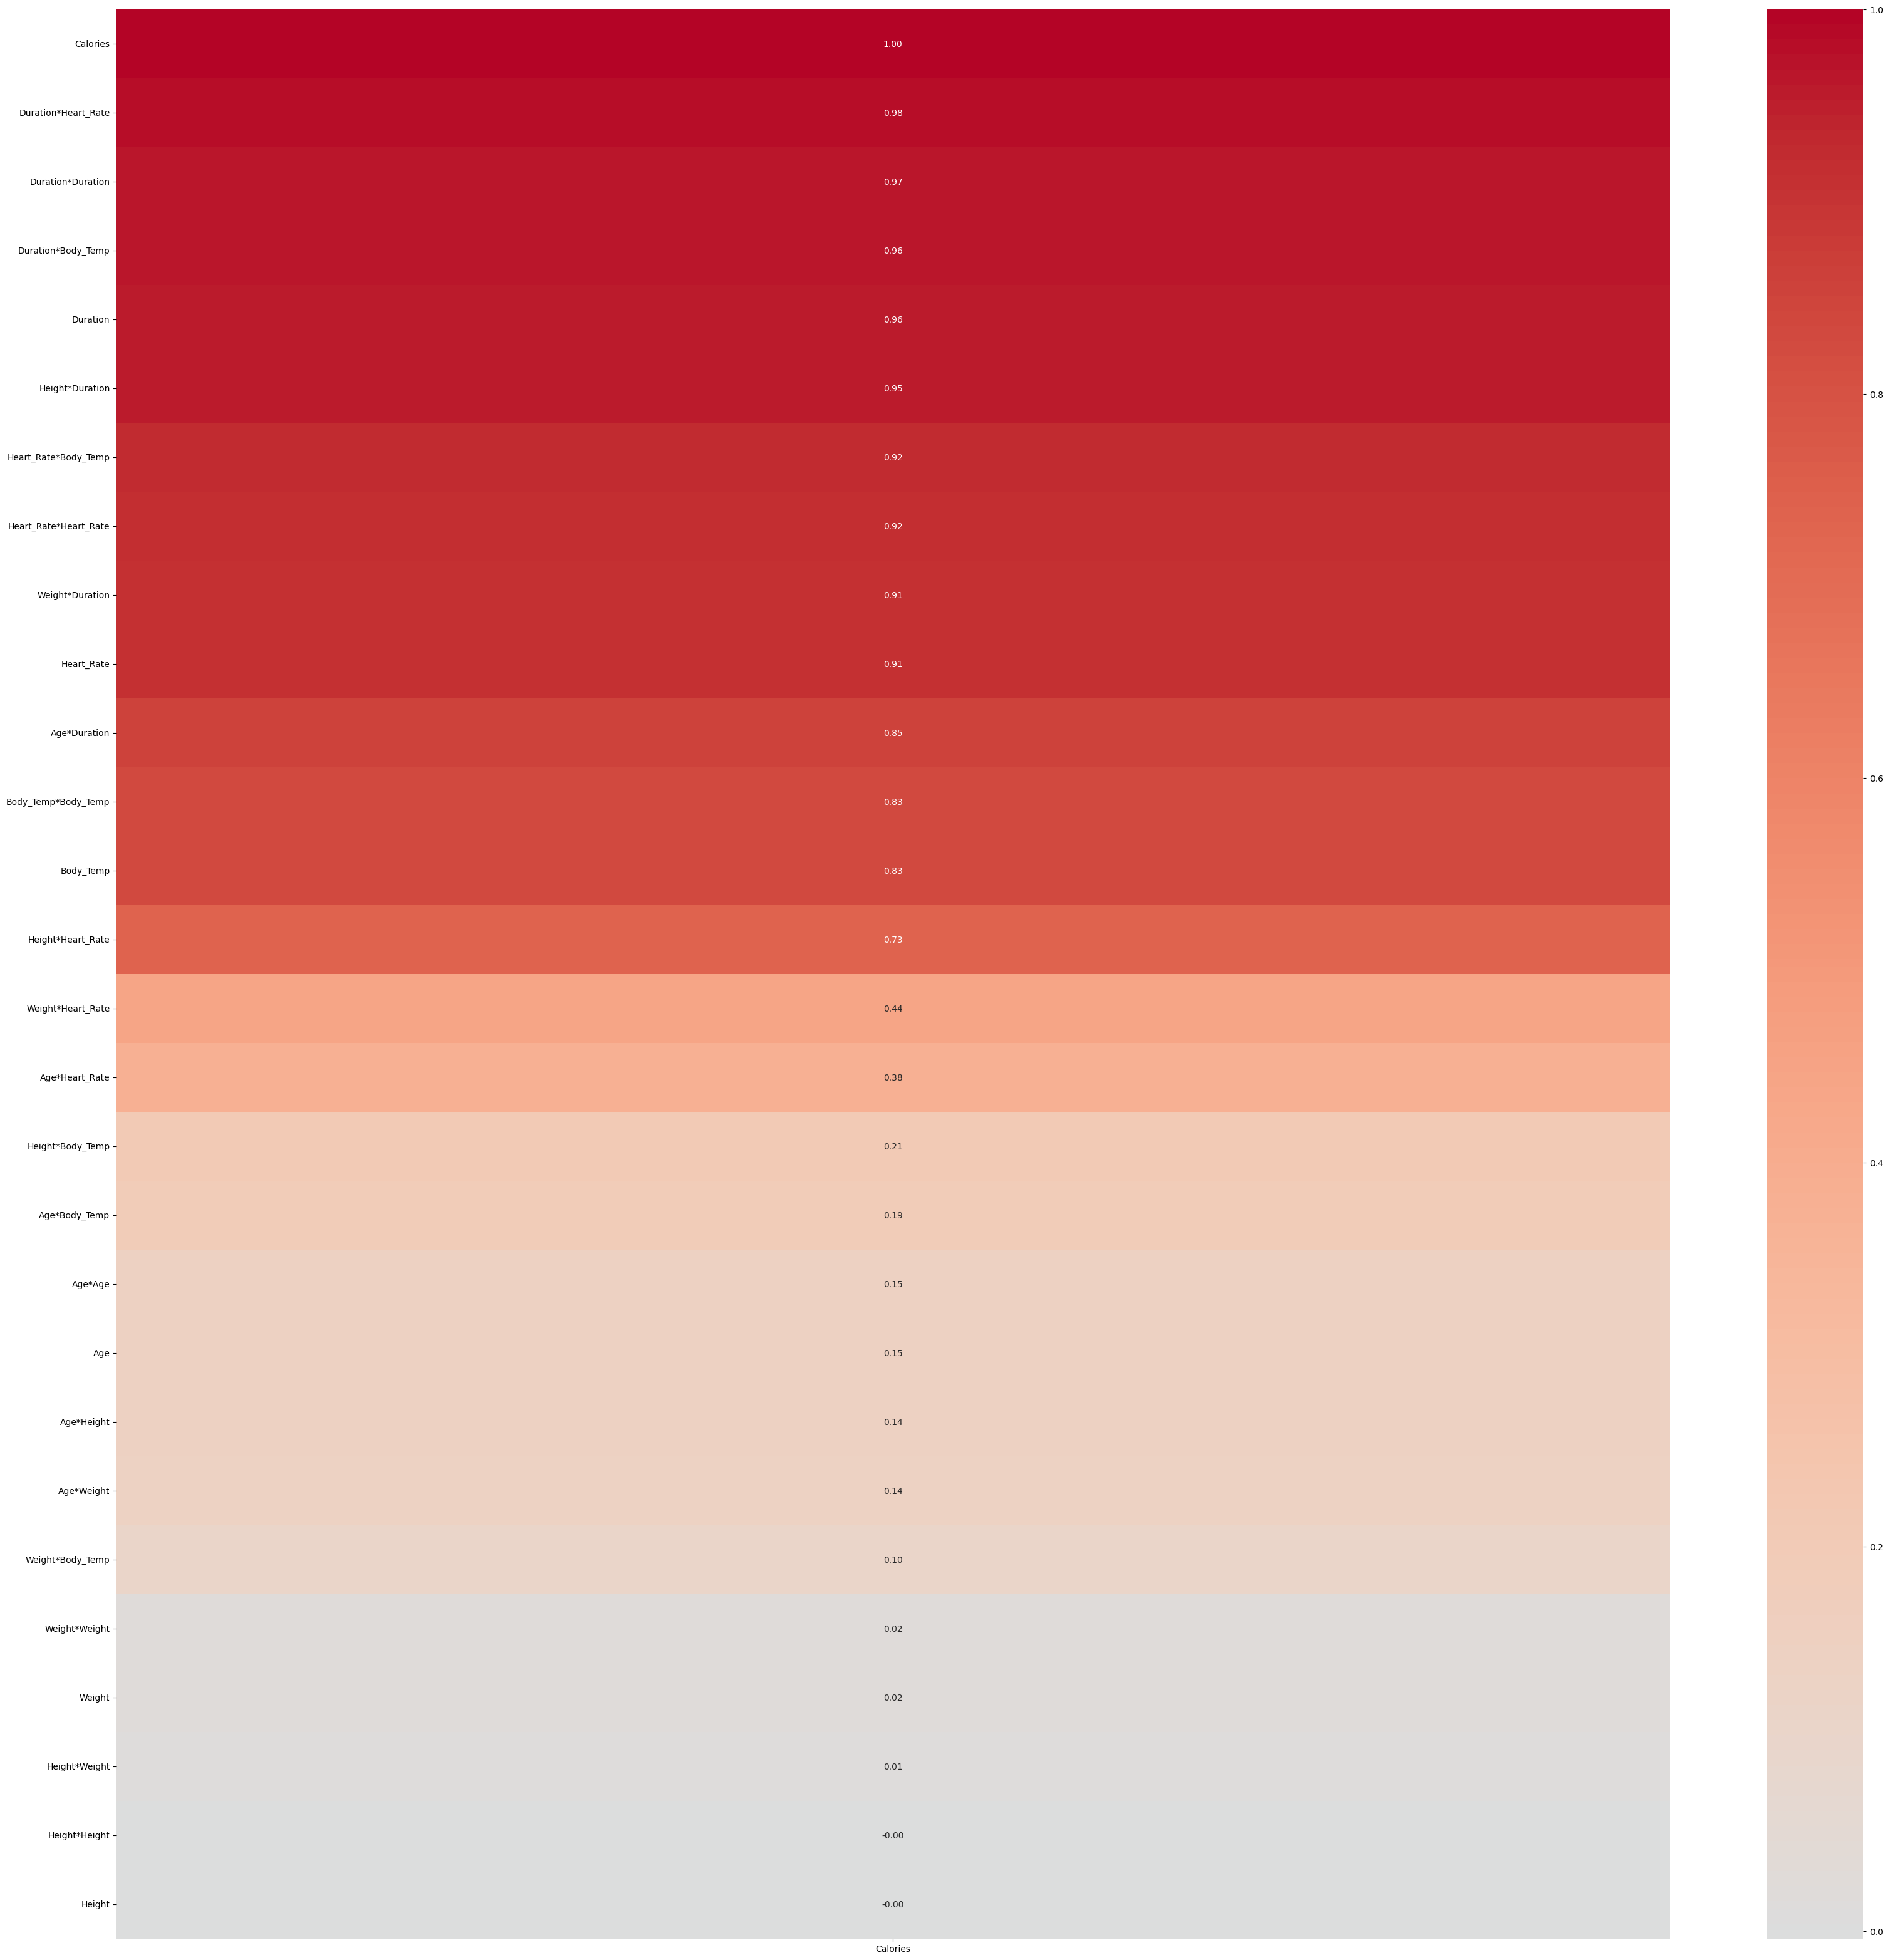

In [8]:
import seaborn as sns
plt.figure(figsize=(40,40))
sns.heatmap(
    corr_matrix_calorie,
    annot=True,
    cmap='coolwarm',
    center=0,
    fmt='.2f'
)

In [9]:
threshold=0.22
releavant_features=corr_matrix_calorie[abs(corr_matrix_calorie)>threshold].dropna().index.to_list()
data_filtered=data[releavant_features]

In [10]:
corr_matrix=data_filtered.drop(columns=["Calories"]).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
multicollinear_columns = [column for column in upper.columns if any(upper[column] > 0.97)]
data_final = data_filtered.drop(columns=multicollinear_columns)
data=data_final

In [11]:
data

,Calories,Duration*Heart_Rate,Heart_Rate*Body_Temp,Age*Duration,Body_Temp*Body_Temp,Height*Heart_Rate,Weight*Heart_Rate,Age*Heart_Rate
0,150.0,2626.0,4141.0,936.0,1681.00,19089.0,8282.0,3636.0
1,34.0,680.0,3374.5,512.0,1576.09,13855.0,5100.0,5440.0
2,29.0,588.0,3343.2,357.0,1584.04,13524.0,5376.0,4284.0
3,140.0,2625.0,4273.5,500.0,1656.49,20160.0,9450.0,2100.0
4,146.0,2550.0,4141.2,950.0,1648.36,16932.0,6222.0,3876.0
...,...,...,...,...,...,...,...,...
749995,230.0,3420.0,4662.6,840.0,1672.81,22002.0,11058.0,3192.0
749996,96.0,1656.0,3726.0,1152.0,1640.25,15180.0,5796.0,5888.0
749997,221.0,3277.0,4621.7,1740.0,1672.81,18306.0,7571.0,6780.0
749998,109.0,1734.0,4110.6,765.0,1624.09,18564.0,9282.0,4590.0


In [12]:
X = data.drop(columns=["Calories"])
#target variables
y = data['Calories']

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=2)


In [13]:
X_train

,Duration*Heart_Rate,Heart_Rate*Body_Temp,Age*Duration,Body_Temp*Body_Temp,Height*Heart_Rate,Weight*Heart_Rate,Age*Heart_Rate
651704,1615.0,3809.5,884.0,1608.01,15105.0,5415.0,4940.0
210962,1274.0,3649.1,280.0,1608.01,15106.0,6097.0,1820.0
721963,2828.0,4130.9,1316.0,1672.81,18584.0,8787.0,4747.0
587936,1116.0,3729.3,384.0,1608.01,15810.0,6324.0,2976.0
143823,174.0,3332.1,128.0,1466.89,14268.0,5307.0,5568.0
...,...,...,...,...,...,...,...
84434,1157.0,3586.7,416.0,1624.09,16376.0,6319.0,2848.0
437782,890.0,3524.4,270.0,1568.16,17622.0,8811.0,2403.0
620104,1144.0,3511.2,572.0,1592.01,13992.0,5104.0,3872.0
203245,3052.0,4447.2,644.0,1664.64,20710.0,10137.0,2507.0


In [14]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
# X_train=X_train.sample(100000)
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

Selecting best hyperparameters

In [15]:
import keras_tuner as kt
import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from keras.layers import Dense,BatchNormalization,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K


def build_model(hp):
    model=Sequential()
    counter=0
    for i in range(hp.Int('num_layers',1,5)):
        units=hp.Int(f'units{i}',min_value=8,max_value=128,step=8)
        activation=hp.Choice(f'activation{i}',values=['relu','tanh','sigmoid','selu','linear'])
        dropout_rate=hp.Choice(f'dropout{i}',values=np.arange(0.1,0.9,0.1).tolist())

        if i==0:
            model.add(Dense(units,activation=activation,input_dim=X_train.shape[1]))
            model.add(Dropout(dropout_rate)) 
            model.add(BatchNormalization())

        else:
            model.add(Dense(units,activation=activation))
            model.add(Dropout(dropout_rate)) 
            model.add(BatchNormalization())

    model.add(Dense(1,activation='linear'))

    model.compile(
            optimizer=hp.Choice('optimizer',values=['adam','rmsprop', 'adagrad', 'sgd', 'nadam', 'adadelta']),
            loss='mean_squared_error'
        )
    return model

tuner=kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    directory=(r"C:\Users\DUSHYANT\Desktop\dir"),
    project_name='calorie_tuning'
)


callback=EarlyStopping(monitor='val_loss',
                       min_delta=0.01,
                       patience=10,
                       mode='auto',
                       verbose=1,
                       baseline=None,
                       restore_best_weights=True)

tuner.search(X_train,y_train,epochs=5,validation_data=(X_test,y_test))

best_hp=tuner.get_best_hyperparameters()[0]




Trial 20 Complete [00h 02m 28s]
val_loss: 23.929277420043945

Best val_loss So Far: 23.929277420043945
Total elapsed time: 03h 40m 39s


Training the model

In [18]:
model=tuner.get_best_models(num_models=1)[0]
# Early stopping callback
callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    mode='auto',
    verbose=1,
    restore_best_weights=True
)

history=model.fit(X_train,y_train,
                  
                  epochs=200,
                  initial_epoch=5,
                  validation_data=(X_test,y_test),
                  callbacks=callback)

Epoch 6/200


C:\Users\DUSHYANT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\DUSHYANT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 8 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


18750/18750 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step - loss: 182.5941 - val_loss: 38.0199
Epoch 7/200
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step - loss: 179.8210 - val_loss: 25.8867
Epoch 8/200
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step - loss: 182.7111 - val_loss: 23.9579
Epoch 9/200
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - loss: 184.5292 - val_loss: 27.0114
Epoch 10/200
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step - loss: 183.2067 - val_loss: 36.9240
Epoch 11/200
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 180.0387 - val_loss: 53.7726
Epoch 12/200
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - loss: 179.6249 - val_loss: 28.9912
Epoch 13/200
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - loss: 180.4322 - val_loss: 28.8615
Epoch 14/200
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step - loss: 184.7410 - val_loss: 22.6551
Epoch 15/200
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step - loss: 178.7934 - val_loss: 26.9032
Epoch 16/200
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/st

In [19]:
print(best_hp.values)
print(f"Best val_accuracy during fine-tuning: {max(history.history['val_loss']):.4f}")

{'num_layers': 1, 'units0': 48, 'activation0': 'relu', 'dropout0': 0.1, 'optimizer': 'rmsprop', 'units1': 40, 'activation1': 'sigmoid', 'dropout1': 0.2, 'units2': 64, 'activation2': 'linear', 'dropout2': 0.4, 'units3': 88, 'activation3': 'tanh', 'dropout3': 0.1, 'units4': 128, 'activation4': 'sigmoid', 'dropout4': 0.6}
Best val_accuracy during fine-tuning: 79.7735


saving the model

In [25]:
# Save the ANN model
model.save('calorie_ann_model.keras')

# Save the scaler
import joblib
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 48)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48)             │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,156 (4.52 KB)

 Trainable params: 529 (2.07 KB)

 Non-trainable params: 96 (384.00 B)

 Optimizer params: 531 (2.08 KB)